In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
import seaborn as sns
import zipfile, glob, json
import matplotlib.pyplot as plt
import statsmodels.api as sm
import datetime
import data_processing
from sqlalchemy import create_engine
from sklearn import preprocessing
from scipy.interpolate import interp1d
from scipy.stats import scoreatpercentile
pd.options.display.max_columns = 500
pd.options.display.max_rows = 10000
%matplotlib inline
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=1.25)

In [2]:
min_max_scaler = preprocessing.MinMaxScaler()
scaler = preprocessing.StandardScaler()
imputer = preprocessing.Imputer()

## Load data

In [3]:
df_bart_import = pd.read_pickle('../data/bart/df_bart_hourly.pkl')
df_noaa_import =  pd.read_pickle('../data/noaa/daily/df_noaa_daily.pkl')

In [4]:
engine = create_engine("postgres://postgres@/forecast")
conn = engine.connect()
df_forecast_import = pd.read_sql("SELECT * FROM forecast_daily", con=engine)
conn.close()
engine.dispose()

In [5]:
df_forecast_import.tail()

,apparenttemperaturemax,apparenttemperaturemin,precipintensity,precipintensitymax,pressure,temperaturemax,temperaturemin,time,windspeed
2045,71.85,52.51,0.0,0.0,1016.26,71.85,52.51,1463036400,5.41
2046,69.14,55.51,0.0,0.0,1014.58,69.14,55.51,1463122800,6.94
2047,66.86,55.66,0.0,0.0,1016.01,66.86,55.66,1463209200,8.86
2048,65.42,54.45,0.0,0.0,1015.70,65.42,54.45,1463295600,6.95
2049,65.16,52.59,0.0,0.0,1015.36,65.16,52.59,1463382000,8.75


In [6]:
pd.to_datetime(df_forecast_import['time'], unit='s')

0      2010-09-01 07:00:00
1      2010-09-02 07:00:00
2      2010-09-03 07:00:00
3      2010-09-04 07:00:00
4      2010-09-05 07:00:00
5      2010-09-06 07:00:00
6      2010-09-07 07:00:00
7      2010-09-08 07:00:00
8      2010-09-09 07:00:00
9      2010-09-10 07:00:00
10     2010-09-11 07:00:00
11     2010-09-12 07:00:00
12     2010-09-13 07:00:00
13     2010-09-14 07:00:00
14     2010-09-15 07:00:00
15     2010-09-16 07:00:00
16     2010-09-17 07:00:00
17     2010-09-18 07:00:00
18     2010-09-19 07:00:00
19     2010-09-20 07:00:00
20     2010-09-21 07:00:00
21     2010-09-22 07:00:00
22     2010-09-23 07:00:00
23     2010-09-24 07:00:00
24     2010-09-25 07:00:00
25     2010-09-26 07:00:00
26     2010-09-27 07:00:00
27     2010-09-28 07:00:00
28     2010-09-29 07:00:00
29     2010-09-30 07:00:00
30     2010-10-01 07:00:00
31     2010-10-02 07:00:00
32     2010-10-03 07:00:00
33     2010-10-04 07:00:00
34     2010-10-05 07:00:00
35     2010-10-06 07:00:00
36     2010-10-07 07:00:00
3

In [7]:
df_forecast_import.columns

Index([u'apparenttemperaturemax', u'apparenttemperaturemin',
       u'precipintensity', u'precipintensitymax', u'pressure',
       u'temperaturemax', u'temperaturemin', u'time', u'windspeed'],
      dtype='object')

## BART graphs

In [9]:
df_bart = df_bart_import.copy()
df_bart_weekly = df_bart.resample('1W').sum()

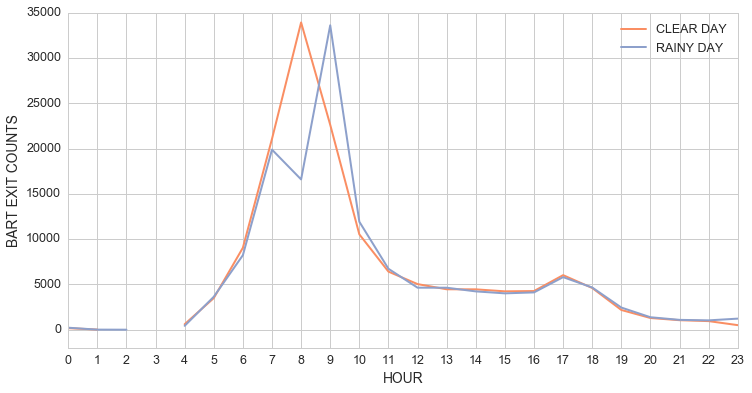

In [10]:
plt.figure(figsize=(12,6))
# xnew = np.linspace(0, 23, 30)
# f = interp1d(range(0,24), df_bart['20141209'].resample('H', how='sum')['counts'])
# f2 = interp1d(range(0,24), df_bart['20141203'].resample('H', how='sum')['counts'])
# plt.plot(xnew, f(xnew), lw=3, color=sns.color_palette('Set2')[1], label='CLEAR DAY', alpha=1)
# plt.plot(xnew, f2(xnew), lw=3, color=sns.color_palette('Set2')[2], label='RAINY DAY', alpha=1)
plt.plot(range(0,24), df_bart['20141209'].resample('H').sum(), lw=2, color=sns.color_palette('Set2')[1], label='CLEAR DAY', alpha=1)
plt.plot(range(0,24), df_bart['20141203'].resample('H').sum(), lw=2, color=sns.color_palette('Set2')[2], label='RAINY DAY', alpha=1)
plt.xlim(0,23)
plt.ylim(-2000,35000)
plt.xticks(range(0,24))
# plt.title('RAIN EFFECT')
plt.xlabel('HOUR')
plt.ylabel('BART EXIT COUNTS')
plt.legend()
# plt.savefig('../images/rain_effect.png')

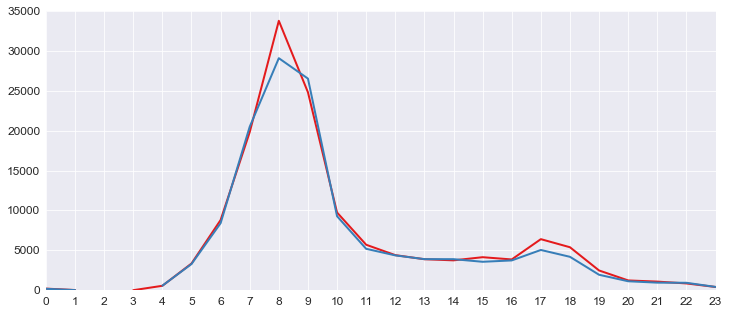

In [11]:
sns.set(context='paper', style='darkgrid', 
            palette='Set1', font='sans-serif', 
            font_scale=1.5)
plt.figure(figsize=(12,5))
plt.plot(range(0,24), df_bart['20150928'].resample('H').sum(), lw=2, markevery=1000)
plt.plot(range(0,24), df_bart['20150126'].resample('H').sum(), lw=2, markevery=1000)
plt.tight_layout
plt.xlim(0,23)
plt.xticks(range(0,24))
plt.savefig('../images/cold_effect.png')

In [12]:
# sns.set(context='paper', style='darkgrid', 
#             palette='Set1', font='sans-serif', 
#             font_scale=1.5)
# plt.figure(figsize=(12,5))
# plt.plot(range(0,24), df_bart[df_coldest_tuesday.index].resample('H', how='sum'), lw=2, markevery=1000)
# plt.plot(range(0,24), df_bart[df_warmest_tuesday.index].resample('H', how='sum'), lw=2, markevery=1000)
# plt.tight_layout
# plt.xlim(0,23)
# plt.xticks(range(0,24))
# plt.savefig('../images/cold_effect.png')

In [14]:
# cold_dates = df_coldest_tuesday.index
# warm_dates = df_warmest_tuesday.index

In [15]:
# df_list = []
# for i, x in enumerate(warm_dates):
#     df_temp (df_bart[str(x)[:10]]['counts'].resample('H', how='sum'))
#     df_temp['hour'] = pd.DatetimeIndex(df_temp.index).hour
#     df_list.append(df_temp)
# df_all = pd.concat(df_list, axis=1)

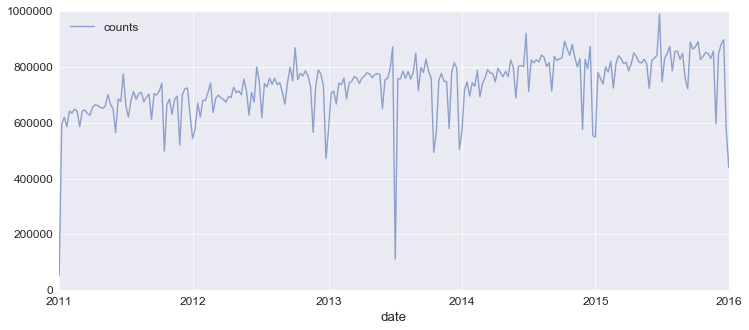

In [16]:
df_bart_weekly.plot(figsize=(12,5), color=sns.color_palette('Set2')[2])

## Forecast.io data

In [17]:
df_forecast = df_forecast_import.copy()

In [18]:
df_forecast['time'] = pd.to_datetime(df_forecast['time'], unit='s')
df_forecast.set_index('time', inplace=True)

In [19]:
# df_forecast.drop(['apparenttemperaturemaxtime', 'apparenttemperaturemintime', 'cloudcover',
# 'dewpoint', 'humidity', 'moonphase', 'ozone', 'precipintensity',
# 'precipintensitymax', 'precipintensitymaxtime', 'precipprobability',
# 'sunrisetime', 'sunsettime', 'temperaturemaxtime', 'temperaturemintime',
# 'visibility', 'windbearing'], axis=1, inplace=True)

In [20]:
df = df_forecast['20110101':'20151231'].copy()
df = df.resample('1D').mean()

In [21]:
df['dayofweek'] = pd.DatetimeIndex(df.index).weekday
df['dayofyear'] = pd.DatetimeIndex(df.index).dayofyear
df['weekofyear'] = pd.DatetimeIndex(df.index).weekofyear

In [22]:
df['month'] = pd.DatetimeIndex(df.index).month
seasons = {1:1,2:2,3:2,4:2,5:3,6:3,
           7:3,8:4,9:4,10:4,11:1,12:1}
df["seasons"] = df["month"].map(seasons)

In [23]:
cal = calendar()
holidays = cal.holidays(start=df.index.min(), end=df.index.max())
holidays
df['holiday'] = 0
df.loc[df.index.isin(holidays), 'holiday'] = 1

In [24]:
df.head()

,apparenttemperaturemax,apparenttemperaturemin,precipintensity,precipintensitymax,pressure,temperaturemax,temperaturemin,windspeed,dayofweek,dayofyear,weekofyear,month,seasons,holiday
time,,,,,,,,,,,,,,
2011-01-01,45.00,38.45,0.0252,0.16,1017.15,48.3,44.1,5.47,5,1,52,1,1,0
2011-01-02,44.55,40.16,0.0306,0.16,1014.48,49.0,46.0,9.40,6,2,52,1,1,0
2011-01-03,51.00,41.08,NaN,NaN,1018.79,51.0,46.0,7.24,0,3,1,1,1,0
2011-01-04,52.00,37.86,NaN,NaN,1024.54,52.0,43.0,7.97,1,4,1,1,1,0
2011-01-05,53.00,38.82,NaN,NaN,1026.22,53.0,45.0,8.17,2,5,1,1,1,0


In [26]:
df_forecast_weekly = df_forecast['20110101':'20151231'].resample('1W').mean()

In [27]:
df.tail()

,apparenttemperaturemax,apparenttemperaturemin,precipintensity,precipintensitymax,pressure,temperaturemax,temperaturemin,windspeed,dayofweek,dayofyear,weekofyear,month,seasons,holiday
time,,,,,,,,,,,,,,
2015-12-27,43.57,34.88,NaN,NaN,1023.15,47.00,41.00,6.40,6,361,52,12,1,0
2015-12-28,48.00,33.58,NaN,NaN,1017.21,48.00,41.01,3.50,0,362,53,12,1,0
2015-12-29,52.11,42.57,NaN,NaN,1018.93,52.11,45.19,1.87,1,363,53,12,1,0
2015-12-30,42.61,38.66,NaN,NaN,1023.50,48.00,43.53,5.94,2,364,53,12,1,0
2015-12-31,51.00,36.56,NaN,NaN,1022.52,51.00,43.22,8.24,3,365,53,12,1,0


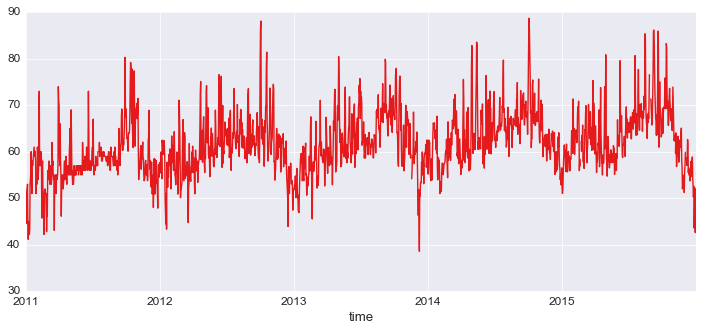

In [28]:
df.apparenttemperaturemax.plot(figsize=(12,5))

In [29]:
#find temperature quartiles
for x in range(75, 91):
    print x, scoreatpercentile(df_forecast.apparenttemperaturemin, x)

75 55.94
76 56.0
77 56.1073
78 56.22
79 56.47
80 56.86
81 56.99
82 57.11
83 57.3767
84 57.75
85 57.88
86 58.0
87 58.11
88 58.47
89 58.94
90 59.11


In [30]:
#find temperature quartiles
for x in range(10, 26):
    print x, scoreatpercentile(df_forecast.apparenttemperaturemin, x)

10 43.299
11 43.5639
12 43.9976
13 44.36
14 44.663
15 44.904
16 45.2584
17 45.64
18 45.9746
19 46.2831
20 46.706
21 47.0
22 47.4
23 47.8427
24 48.29
25 49.0


In [31]:
df[(df.holiday == 0) & (df.dayofweek >= 1) & (df.dayofweek <= 2) & (df.apparenttemperaturemin < 43) ].sort_values('apparenttemperaturemin', 
                                                         ascending = False).head()

,apparenttemperaturemax,apparenttemperaturemin,precipintensity,precipintensitymax,pressure,temperaturemax,temperaturemin,windspeed,dayofweek,dayofyear,weekofyear,month,seasons,holiday
time,,,,,,,,,,,,,,
2011-03-02,56.00,42.95,0.0118,0.04,1017.22,56.00,49.00,9.17,2,61,9,3,2,0
2011-12-21,57.05,42.81,NaN,NaN,1018.16,57.05,45.75,3.47,2,355,51,12,1,0
2013-01-08,56.40,42.78,NaN,NaN,1022.22,56.40,47.23,4.05,1,8,2,1,1,0
2011-04-13,53.00,42.74,NaN,NaN,1023.34,53.00,48.00,8.73,2,103,15,4,2,0
2015-12-29,52.11,42.57,NaN,NaN,1018.93,52.11,45.19,1.87,1,363,53,12,1,0


In [32]:
df[(df.holiday == 0) & (df.dayofweek >= 1) & (df.dayofweek <= 2) & (df.apparenttemperaturemin > 60) ].sort_values('apparenttemperaturemin', 
                                                         ascending = True).head()

,apparenttemperaturemax,apparenttemperaturemin,precipintensity,precipintensitymax,pressure,temperaturemax,temperaturemin,windspeed,dayofweek,dayofyear,weekofyear,month,seasons,holiday
time,,,,,,,,,,,,,,
2013-09-04,68.52,60.10,NaN,NaN,1014.92,68.52,60.10,7.76,2,247,36,9,4,0
2014-08-27,69.04,60.11,NaN,NaN,1016.26,69.04,60.11,6.68,2,239,35,8,4,0
2015-08-18,67.40,60.11,NaN,NaN,1012.25,67.40,60.11,7.43,1,230,34,8,4,0
2014-10-14,67.99,60.11,NaN,NaN,1011.16,67.99,60.11,5.95,1,287,42,10,4,0
2014-08-12,67.18,60.11,NaN,NaN,1013.81,67.18,60.11,7.14,1,224,33,8,4,0


In [33]:
# df_warmest_tuesday = df[(df.holiday == 0) & (df.dayofweek == 1)].sort_values('apparenttemperaturemax', ascending = False).head(10)

In [36]:
# df_coldest_tuesday =  df[(df.holiday == 0) & (df.dayofweek == 1)].sort_values('apparenttemperaturemin').head(10)

## NOAA weather data

In [37]:
df_noaa_daily = df_noaa_import.copy()

In [38]:
numeric_cols = ['Tmax', 'Tmin', 'Tavg', 'DewPoint', 'WetBulb', 'Heat', 
                'Cool', 'PrecipTotal', 'ResultSpeed', 'ResultDir', 
                'AvgSpeed', 'Max5Speed', 'Max5Dir', 'Max2Speed', 'Max2Dir']

for col in numeric_cols:
    df_noaa_daily[col].replace('  T', 0, inplace=True)
    df_noaa_daily[col].replace(' ', 0, inplace=True)
    df_noaa_daily[col] = pd.to_numeric(df_noaa_daily[col], errors='coerce')
#     df_noaa_daily[df_noaa_daily[col].isnull()] = df_noaa_daily[col].mean()

In [36]:
df_noaa_daily.drop(['WBAN', 'YearMonthDay', 'ResultSpeed', 'ResultDir', 'Heat', 'Cool', 'WetBulb',
                    'Max5Speed', 'Max5Dir', 'Max2Speed', 'Max2Dir'], axis=1, inplace=True)

In [37]:
df_noaa_daily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2011-01-01 to 2015-12-31
Data columns (total 6 columns):
Tmax           1825 non-null float64
Tmin           1825 non-null float64
Tavg           1816 non-null float64
DewPoint       1824 non-null float64
PrecipTotal    1825 non-null float64
AvgSpeed       1824 non-null float64
dtypes: float64(6)
memory usage: 99.9 KB


In [38]:
df_noaa_weekly = df_noaa_daily.resample('1W', how={'Tmax': np.mean, 'PrecipTotal': np.mean, 
                                            'DewPoint': np.mean})

/Applications/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  from ipykernel import kernelapp as app


In [39]:
df_noaa_import.head()

,WBAN,YearMonthDay,Tmax,Tmin,Tavg,DewPoint,WetBulb,Heat,Cool,PrecipTotal,ResultSpeed,ResultDir,AvgSpeed,Max5Speed,Max5Dir,Max2Speed,Max2Dir
date,,,,,,,,,,,,,,,,,
2011-01-01,23234,20110101,52,47,50,44,47,15,0,0.09,8.3,12,9.2,25,120,20,120
2011-01-02,23234,20110102,51,48,50,45,48,15,0,0.35,6.0,05,9.3,25,110,22,110
2011-01-03,23234,20110103,53,45,49,44,47,16,0,0.00,2.8,04,3.7,13,070,12,060
2011-01-04,23234,20110104,53,39,46,41,44,19,0,0.00,0.8,01,1.1,12,010,8,060
2011-01-05,23234,20110105,55,38,47,40,43,18,0,0.00,3.2,10,4.6,15,060,14,050


In [40]:
df_bart_weekly['counts_scaled'] = data_processing.standardize(df_bart_weekly.counts)
df_forecast_weekly['tempmax_scaled'] = data_processing.standardize(df_forecast_weekly.apparenttemperaturemax)
df_forecast_weekly['pressure_scaled'] = data_processing.standardize(df_forecast_weekly.pressure)
df_forecast_weekly['wind_scaled'] = data_processing.standardize(df_forecast_weekly.windspeed)
# df_noaa_daily['temp_scaled'] = data_processing.standardize(df_noaa_daily.DryBulbFarenheit)
df_noaa_weekly['precip_scaled'] = data_processing.standardize(df_noaa_daily.PrecipTotal)

## BART data

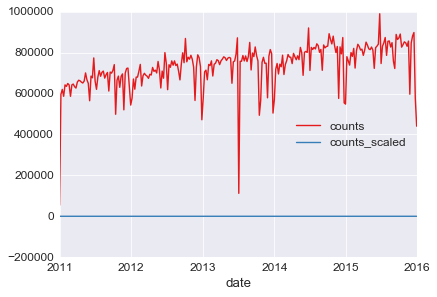

In [41]:
df_bart_weekly.plot()

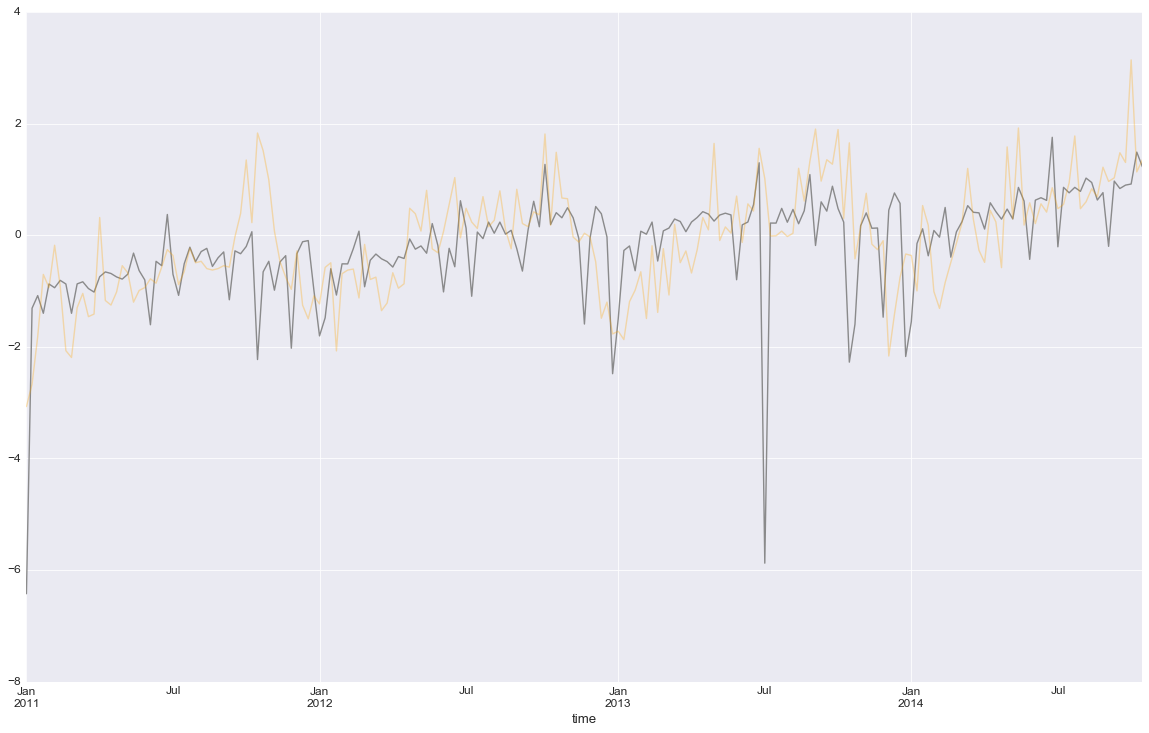

In [42]:
df_bart_weekly['20110101':'20141019']['counts_scaled'].plot(figsize=(20,12), color = 'gray', alpha=0.9, label='bart counts')
df_forecast_weekly['20110101':'20141019']['tempmax_scaled'].plot(figsize=(20,12), color = 'orange', alpha=0.3, label='temperature')
# df_noaa_weekly['20110101':'20141019']['precip_scaled'].plot(figsize=(20,12), color = 'lightblue', alpha=0.4, label='rain')

## Cross Correlation

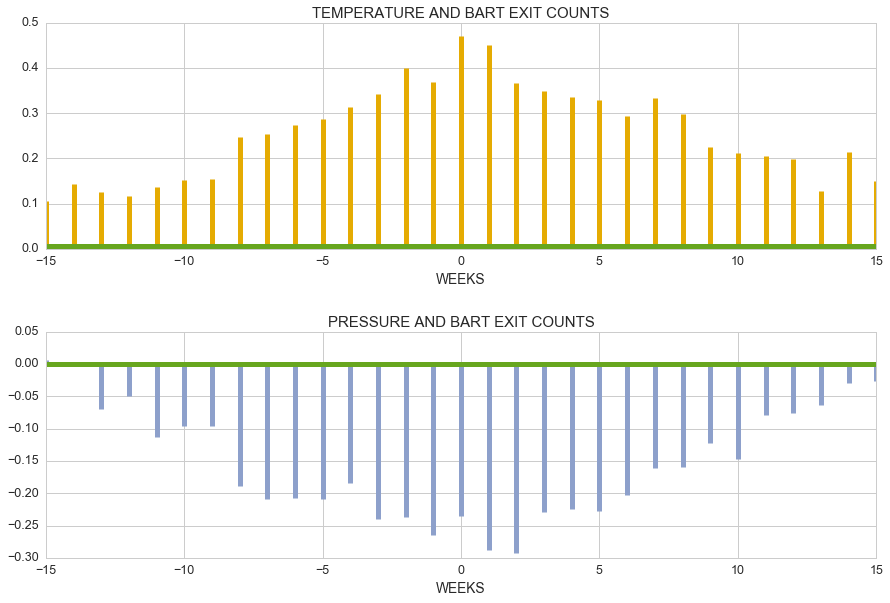

In [43]:
sns.set(context='notebook', style='whitegrid', font='sans-serif', font_scale=1.25)
fig = plt.figure(figsize=(13,9))
ax1 = fig.add_subplot(211)
ax1.xcorr(df_forecast_weekly.tempmax_scaled, df_bart_weekly.counts_scaled, 
          usevlines=True, maxlags=15, normed=True, lw=5, color=sns.color_palette('Dark2')[5])
ax1.grid(True)
ax1.axhline(0, lw=10, color=sns.color_palette('Dark2')[4])
ax1.set_xlabel('WEEKS')
ax1.set_title('TEMPERATURE AND BART EXIT COUNTS')

ax2 = fig.add_subplot(212, sharex=ax1)
ax2.xcorr(df_forecast_weekly.pressure_scaled, df_bart_weekly.counts_scaled, 
          usevlines=True, normed=True, maxlags=15, lw=5, color=sns.color_palette('Set2')[2])
ax2.grid(True)
ax2.axhline(0, lw=5, color=sns.color_palette('Dark2')[4])
ax2.set_xlabel('WEEKS')
ax2.set_title('PRESSURE AND BART EXIT COUNTS')

# ax3 = fig.add_subplot(313, sharex=ax1)
# ax3.xcorr(df_forecast_weekly.wind_scaled, df_bart_weekly.counts_scaled, usevlines=True, normed=True, maxlags=50, lw=2)
# ax3.grid(True)
# ax3.axhline(0, color='black', lw=2)
# ax3.set_xlabel('weeks')
# ax3.set_title('Cross-correlation: Weekly Temperature and Precipitation')

fig.tight_layout(pad = 2)
plt.show()
# fig.savefig('../images/xcorr-temp-pressure.png')